In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchsummary import summary
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import numpy as np

# -----------------------------
# 1. Data Preprocessing
# -----------------------------
data_dir = "/kaggle/input/ju-cricket/Cricket_Dataset_final/Task_B"

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], 
                         [0.229, 0.224, 0.225])
])

train_ds = datasets.ImageFolder(f"{data_dir}/train/Bowling", transform=transform)
val_ds   = datasets.ImageFolder(f"{data_dir}/val/Bowling", transform=transform)
test_ds  = datasets.ImageFolder(f"{data_dir}/test/Bowling", transform=transform)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=32, shuffle=False)

classes = train_ds.classes
print("Classes:", classes)

Classes: ['fast_bowl', 'spin_bowl']


In [2]:
print("Total training images:", len(train_ds))
print("Total validation images:", len(val_ds))
print("Total test images:", len(test_ds))

total_images = len(train_ds) + len(val_ds) + len(test_ds)
print("Total images in dataset:", total_images)

Total training images: 1710
Total validation images: 432
Total test images: 549
Total images in dataset: 2691


In [3]:
ignore_folder = "random_occlusion"

def count_images_ignore_folder(dataset, ignore_folder):
    count = 0
    for img_path, label in dataset.samples:
        # Skip if the image path contains the ignore_folder
        if ignore_folder not in img_path.split("/"):
            count += 1
    return count

train_count = count_images_ignore_folder(train_ds, ignore_folder)
val_count   = count_images_ignore_folder(val_ds, ignore_folder)
test_count  = count_images_ignore_folder(test_ds, ignore_folder)

total_count = train_count + val_count + test_count

print("Training images (excluding '{}'): {}".format(ignore_folder, train_count))
print("Validation images (excluding '{}'): {}".format(ignore_folder, val_count))
print("Test images (excluding '{}'): {}".format(ignore_folder, test_count))
print("Total images (excluding '{}'): {}".format(ignore_folder, total_count))

Training images (excluding 'random_occlusion'): 1520
Validation images (excluding 'random_occlusion'): 384
Test images (excluding 'random_occlusion'): 488
Total images (excluding 'random_occlusion'): 2392


In [4]:
ignore_folder = "random_occlusionw"

def get_included_folders(dataset, ignore_folder):
    included = set()
    for img_path, label in dataset.samples:
        # Split the path into parts and ignore if ignore_folder is in the path
        if ignore_folder not in img_path.split("/"):
            # The folder name just above the image (or the class folder)
            folder_name = img_path.split("/")[-2]
            included.add(folder_name)
    return included

train_folders = get_included_folders(train_ds, ignore_folder)
val_folders   = get_included_folders(val_ds, ignore_folder)
test_folders  = get_included_folders(test_ds, ignore_folder)

print("Training folders considered:", train_folders)
print("Validation folders considered:", val_folders)
print("Test folders considered:", test_folders)

Training folders considered: {'lens_flare', 'dirty_lens', 'motion_blur', 'blur', 'original', 'low_resolution', 'chromatic_aberration', 'gaussian_noise', 'random_occlusion'}
Validation folders considered: {'lens_flare', 'dirty_lens', 'motion_blur', 'blur', 'original', 'low_resolution', 'chromatic_aberration', 'gaussian_noise', 'random_occlusion'}
Test folders considered: {'lens_flare', 'dirty_lens', 'motion_blur', 'blur', 'original', 'low_resolution', 'chromatic_aberration', 'gaussian_noise', 'random_occlusion'}


In [5]:
ignore_folder = "random_occlusion"

def filter_samples(dataset, ignore_folder):
    # Keep only samples where ignore_folder is NOT in the path
    filtered_samples = [s for s in dataset.samples if ignore_folder not in s[0].split("/")]
    dataset.samples = filtered_samples
    dataset.targets = [s[1] for s in filtered_samples]  # Update targets accordingly
    return dataset

# Create original datasets
train_ds = datasets.ImageFolder(f"{data_dir}/train/Bowling", transform=transform)
val_ds   = datasets.ImageFolder(f"{data_dir}/val/Bowling", transform=transform)
test_ds  = datasets.ImageFolder(f"{data_dir}/test/Bowling", transform=transform)

# Filter out 'random_occlusion' folder
train_ds = filter_samples(train_ds, ignore_folder)
val_ds   = filter_samples(val_ds, ignore_folder)
test_ds  = filter_samples(test_ds, ignore_folder)

# DataLoaders
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=32, shuffle=False)

# Classes (will remain the same)
classes = train_ds.classes
print("Classes:", classes)

# Show counts
print("Final Training images:", len(train_ds))
print("Final Validation images:", len(val_ds))
print("Final Test images:", len(test_ds))
print("Total images after filtering:", len(train_ds) + len(val_ds) + len(test_ds))

Classes: ['fast_bowl', 'spin_bowl']
Final Training images: 1520
Final Validation images: 384
Final Test images: 488
Total images after filtering: 2392


In [6]:
ignore_folder = "random_occlusion"

def get_included_folders(dataset, ignore_folder):
    included = set()
    for img_path, label in dataset.samples:
        # Split the path into parts and ignore if ignore_folder is in the path
        if ignore_folder not in img_path.split("/"):
            # The folder name just above the image (or the class folder)
            folder_name = img_path.split("/")[-2]
            included.add(folder_name)
    return included

train_folders = get_included_folders(train_ds, ignore_folder)
val_folders   = get_included_folders(val_ds, ignore_folder)
test_folders  = get_included_folders(test_ds, ignore_folder)

print("Training folders considered:", train_folders)
print("Validation folders considered:", val_folders)
print("Test folders considered:", test_folders)

Training folders considered: {'lens_flare', 'dirty_lens', 'motion_blur', 'blur', 'original', 'low_resolution', 'chromatic_aberration', 'gaussian_noise'}
Validation folders considered: {'lens_flare', 'dirty_lens', 'motion_blur', 'blur', 'original', 'low_resolution', 'chromatic_aberration', 'gaussian_noise'}
Test folders considered: {'lens_flare', 'dirty_lens', 'motion_blur', 'blur', 'original', 'low_resolution', 'chromatic_aberration', 'gaussian_noise'}


In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import numpy as np
import pandas as pd
from tqdm import tqdm
import time
import os
import tempfile

# -----------------------------
# 1. Data Preprocessing with Filtering (EfficientNet-B0 - 224x224)
# -----------------------------
data_dir = "/kaggle/input/ju-cricket/Cricket_Dataset_final/Task_B"

# EfficientNet-B0 uses 224x224 input size (same as ResNet/DenseNet)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # EfficientNet-B0 input size
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], 
                         [0.229, 0.224, 0.225])
])

ignore_folder = "random_occlusion"

def filter_samples(dataset, ignore_folder):
    """Filter out samples containing the ignore_folder in their path"""
    filtered_samples = [s for s in dataset.samples if ignore_folder not in s[0].split("/")]
    dataset.samples = filtered_samples
    dataset.targets = [s[1] for s in filtered_samples]
    return dataset

# Create and filter datasets
print("🔄 Loading and filtering datasets for EfficientNet-B0...")
train_ds = datasets.ImageFolder(f"{data_dir}/train/Bowling", transform=transform)
val_ds   = datasets.ImageFolder(f"{data_dir}/val/Bowling", transform=transform)
test_ds  = datasets.ImageFolder(f"{data_dir}/test/Bowling", transform=transform)

# Apply filtering
train_ds = filter_samples(train_ds, ignore_folder)
val_ds   = filter_samples(val_ds, ignore_folder)
test_ds  = filter_samples(test_ds, ignore_folder)

# Create DataLoaders
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=32, shuffle=False)

# Display information
classes = train_ds.classes
print(f"✅ Classes: {classes}")
print(f"📊 Dataset Statistics:")
print(f"│ Training images: {len(train_ds)}")
print(f"│ Validation images: {len(val_ds)}")
print(f"│ Test images: {len(test_ds)}")
print(f"│ Total images (after filtering): {len(train_ds) + len(val_ds) + len(test_ds)}")
print(f"│ Excluded folder: '{ignore_folder}'")
print(f"│ Number of classes: {len(classes)}")

# -----------------------------
# 2. Pretrained EfficientNet-B0 Model
# -----------------------------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Load pretrained EfficientNet-B0
print("🔄 Loading pretrained EfficientNet-B0 from ImageNet...")
model = models.efficientnet_b0(pretrained=True)

# Replace final classification layer
# EfficientNet-B0 uses model.classifier (similar to DenseNet)
num_features = model.classifier[1].in_features  # Get input features (1280)
model.classifier[1] = nn.Linear(num_features, len(classes))  # Replace final layer
model = model.to(device)

print(f"✅ Model loaded with {len(classes)} output classes")

# Calculate model parameters and size
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

# Calculate model file size
with tempfile.NamedTemporaryFile(delete=False, suffix='.pth') as tmp_file:
    torch.save(model.state_dict(), tmp_file.name)
    model_size_mb = os.path.getsize(tmp_file.name) / (1024 * 1024)
    os.unlink(tmp_file.name)

print(f"📊 Total parameters: {total_params:,}")
print(f"📊 Trainable parameters: {trainable_params:,}")
print(f"📊 Model file size: {model_size_mb:.2f} MB")
print(f"📋 Model Architecture:")
print(f"│ Input size: (3, 224, 224)")
print(f"│ EfficientNet-B0 features: 1280")
print(f"│ Output classes: {len(classes)}")
print(f"│ Compound scaling: Depth/Width/Resolution optimized")


🔄 Loading and filtering datasets for EfficientNet-B0...
✅ Classes: ['fast_bowl', 'spin_bowl']
📊 Dataset Statistics:
│ Training images: 1520
│ Validation images: 384
│ Test images: 488
│ Total images (after filtering): 2392
│ Excluded folder: 'random_occlusion'
│ Number of classes: 2
Using device: cuda
🔄 Loading pretrained EfficientNet-B0 from ImageNet...


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 135MB/s] 


✅ Model loaded with 2 output classes
📊 Total parameters: 4,010,110
📊 Trainable parameters: 4,010,110
📊 Model file size: 15.58 MB
📋 Model Architecture:
│ Input size: (3, 224, 224)
│ EfficientNet-B0 features: 1280
│ Output classes: 2
│ Compound scaling: Depth/Width/Resolution optimized



📋 Training Configuration:
│ Model: EfficientNet-B0 (pretrained)
│ Optimizer: Adam (lr=0.0001)
│ Loss Function: CrossEntropyLoss
│ Batch Size: 32
│ Device: cuda
│ Data: Filtered (excluding 'random_occlusion')

🚀 Starting EfficientNet-B0 Fine-tuning for 50 epochs...

📈 Epoch 1/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:30<00:00,  1.56it/s, Loss=0.6009, Acc=0.6592]


✅ Training completed in 30.79s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:05<00:00,  2.13it/s, Loss=0.6212, Acc=0.6797]


✅ Validation completed in 5.63s
🌟 New best model found! Validation Loss: 0.6212

📊 Epoch 1 Summary:
│ Train Loss: 0.6009 | Train Acc: 0.6592
│ Val Loss:   0.6212 | Val Acc:   0.6797
│ Train Time: 30.79s | Val Time: 5.63s
│ Total Epoch Time: 36.43s
│ Best Val Loss: 0.6212 (Epoch 1)
│ GPU Memory: 0.1GB / 3.2GB

📈 Epoch 2/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:18<00:00,  2.60it/s, Loss=0.3586, Acc=0.8842]


✅ Training completed in 18.44s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:02<00:00,  4.27it/s, Loss=0.6054, Acc=0.6953]


✅ Validation completed in 2.81s
🌟 New best model found! Validation Loss: 0.6054

📊 Epoch 2 Summary:
│ Train Loss: 0.3586 | Train Acc: 0.8842
│ Val Loss:   0.6054 | Val Acc:   0.6953
│ Train Time: 18.44s | Val Time: 2.81s
│ Total Epoch Time: 21.27s
│ Best Val Loss: 0.6054 (Epoch 2)
│ GPU Memory: 0.1GB / 3.2GB

📈 Epoch 3/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:18<00:00,  2.58it/s, Loss=0.1664, Acc=0.9645]


✅ Training completed in 18.62s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:02<00:00,  4.44it/s, Loss=0.7042, Acc=0.6979]


✅ Validation completed in 2.70s

📊 Epoch 3 Summary:
│ Train Loss: 0.1664 | Train Acc: 0.9645
│ Val Loss:   0.7042 | Val Acc:   0.6979
│ Train Time: 18.62s | Val Time: 2.70s
│ Total Epoch Time: 21.33s
│ Best Val Loss: 0.6054 (Epoch 2)
│ GPU Memory: 0.1GB / 3.2GB

📈 Epoch 4/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:18<00:00,  2.58it/s, Loss=0.0627, Acc=0.9941]


✅ Training completed in 18.62s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:02<00:00,  4.67it/s, Loss=0.6576, Acc=0.7448]


✅ Validation completed in 2.57s

📊 Epoch 4 Summary:
│ Train Loss: 0.0627 | Train Acc: 0.9941
│ Val Loss:   0.6576 | Val Acc:   0.7448
│ Train Time: 18.62s | Val Time: 2.57s
│ Total Epoch Time: 21.20s
│ Best Val Loss: 0.6054 (Epoch 2)
│ GPU Memory: 0.1GB / 3.2GB

📈 Epoch 5/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:19<00:00,  2.45it/s, Loss=0.0331, Acc=0.9941]


✅ Training completed in 19.57s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:02<00:00,  4.47it/s, Loss=0.7124, Acc=0.7474]


✅ Validation completed in 2.69s

📊 Epoch 5 Summary:
│ Train Loss: 0.0331 | Train Acc: 0.9941
│ Val Loss:   0.7124 | Val Acc:   0.7474
│ Train Time: 19.57s | Val Time: 2.69s
│ Total Epoch Time: 22.26s
│ Best Val Loss: 0.6054 (Epoch 2)
│ GPU Memory: 0.1GB / 3.2GB

📈 Epoch 6/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:18<00:00,  2.55it/s, Loss=0.0266, Acc=0.9941]


✅ Training completed in 18.83s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:02<00:00,  4.87it/s, Loss=0.6989, Acc=0.7552]


✅ Validation completed in 2.47s

📊 Epoch 6 Summary:
│ Train Loss: 0.0266 | Train Acc: 0.9941
│ Val Loss:   0.6989 | Val Acc:   0.7552
│ Train Time: 18.83s | Val Time: 2.47s
│ Total Epoch Time: 21.30s
│ Best Val Loss: 0.6054 (Epoch 2)
│ GPU Memory: 0.1GB / 3.2GB

📈 Epoch 7/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:18<00:00,  2.61it/s, Loss=0.0189, Acc=0.9967]


✅ Training completed in 18.41s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:03<00:00,  3.61it/s, Loss=0.7382, Acc=0.7734]


✅ Validation completed in 3.33s

📊 Epoch 7 Summary:
│ Train Loss: 0.0189 | Train Acc: 0.9967
│ Val Loss:   0.7382 | Val Acc:   0.7734
│ Train Time: 18.41s | Val Time: 3.33s
│ Total Epoch Time: 21.74s
│ Best Val Loss: 0.6054 (Epoch 2)
│ GPU Memory: 0.1GB / 3.2GB

📈 Epoch 8/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:21<00:00,  2.24it/s, Loss=0.0153, Acc=0.9974]


✅ Training completed in 21.46s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:02<00:00,  4.85it/s, Loss=0.7695, Acc=0.7292]


✅ Validation completed in 2.48s

📊 Epoch 8 Summary:
│ Train Loss: 0.0153 | Train Acc: 0.9974
│ Val Loss:   0.7695 | Val Acc:   0.7292
│ Train Time: 21.46s | Val Time: 2.48s
│ Total Epoch Time: 23.94s
│ Best Val Loss: 0.6054 (Epoch 2)
│ GPU Memory: 0.1GB / 3.2GB

📈 Epoch 9/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:18<00:00,  2.60it/s, Loss=0.0129, Acc=0.9974]


✅ Training completed in 18.44s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:02<00:00,  4.25it/s, Loss=0.8251, Acc=0.7422]


✅ Validation completed in 2.83s

📊 Epoch 9 Summary:
│ Train Loss: 0.0129 | Train Acc: 0.9974
│ Val Loss:   0.8251 | Val Acc:   0.7422
│ Train Time: 18.44s | Val Time: 2.83s
│ Total Epoch Time: 21.28s
│ Best Val Loss: 0.6054 (Epoch 2)
│ GPU Memory: 0.1GB / 3.2GB

📈 Epoch 10/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:18<00:00,  2.60it/s, Loss=0.0109, Acc=0.9987]


✅ Training completed in 18.44s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:03<00:00,  3.94it/s, Loss=0.8306, Acc=0.7500]


✅ Validation completed in 3.05s

📊 Epoch 10 Summary:
│ Train Loss: 0.0109 | Train Acc: 0.9987
│ Val Loss:   0.8306 | Val Acc:   0.7500
│ Train Time: 18.44s | Val Time: 3.05s
│ Total Epoch Time: 21.49s
│ Best Val Loss: 0.6054 (Epoch 2)
│ GPU Memory: 0.1GB / 3.2GB

📈 Epoch 11/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:19<00:00,  2.41it/s, Loss=0.0101, Acc=0.9980]


✅ Training completed in 19.89s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:02<00:00,  4.86it/s, Loss=0.7817, Acc=0.7630]


✅ Validation completed in 2.48s

📊 Epoch 11 Summary:
│ Train Loss: 0.0101 | Train Acc: 0.9980
│ Val Loss:   0.7817 | Val Acc:   0.7630
│ Train Time: 19.89s | Val Time: 2.48s
│ Total Epoch Time: 22.37s
│ Best Val Loss: 0.6054 (Epoch 2)
│ GPU Memory: 0.1GB / 3.2GB

📈 Epoch 12/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:21<00:00,  2.21it/s, Loss=0.0135, Acc=0.9974]


✅ Training completed in 21.68s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:03<00:00,  3.27it/s, Loss=0.7984, Acc=0.7812]


✅ Validation completed in 3.67s

📊 Epoch 12 Summary:
│ Train Loss: 0.0135 | Train Acc: 0.9974
│ Val Loss:   0.7984 | Val Acc:   0.7812
│ Train Time: 21.68s | Val Time: 3.67s
│ Total Epoch Time: 25.36s
│ Best Val Loss: 0.6054 (Epoch 2)
│ GPU Memory: 0.1GB / 3.2GB

📈 Epoch 13/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:21<00:00,  2.20it/s, Loss=0.0105, Acc=0.9967]


✅ Training completed in 21.81s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:03<00:00,  3.66it/s, Loss=0.9593, Acc=0.7266]


✅ Validation completed in 3.28s

📊 Epoch 13 Summary:
│ Train Loss: 0.0105 | Train Acc: 0.9967
│ Val Loss:   0.9593 | Val Acc:   0.7266
│ Train Time: 21.81s | Val Time: 3.28s
│ Total Epoch Time: 25.10s
│ Best Val Loss: 0.6054 (Epoch 2)
│ GPU Memory: 0.1GB / 3.2GB

📈 Epoch 14/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:17<00:00,  2.68it/s, Loss=0.0100, Acc=0.9974]


✅ Training completed in 17.94s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:02<00:00,  4.63it/s, Loss=0.8346, Acc=0.7552]


✅ Validation completed in 2.60s

📊 Epoch 14 Summary:
│ Train Loss: 0.0100 | Train Acc: 0.9974
│ Val Loss:   0.8346 | Val Acc:   0.7552
│ Train Time: 17.94s | Val Time: 2.60s
│ Total Epoch Time: 20.54s
│ Best Val Loss: 0.6054 (Epoch 2)
│ GPU Memory: 0.1GB / 3.2GB

📈 Epoch 15/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:18<00:00,  2.54it/s, Loss=0.0133, Acc=0.9980]


✅ Training completed in 18.93s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:02<00:00,  4.70it/s, Loss=0.8101, Acc=0.7682]


✅ Validation completed in 2.56s

📊 Epoch 15 Summary:
│ Train Loss: 0.0133 | Train Acc: 0.9980
│ Val Loss:   0.8101 | Val Acc:   0.7682
│ Train Time: 18.93s | Val Time: 2.56s
│ Total Epoch Time: 21.50s
│ Best Val Loss: 0.6054 (Epoch 2)
│ GPU Memory: 0.1GB / 3.2GB

📈 Epoch 16/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:18<00:00,  2.57it/s, Loss=0.0086, Acc=0.9974]


✅ Training completed in 18.64s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:02<00:00,  4.65it/s, Loss=0.9734, Acc=0.7188]


✅ Validation completed in 2.58s

📊 Epoch 16 Summary:
│ Train Loss: 0.0086 | Train Acc: 0.9974
│ Val Loss:   0.9734 | Val Acc:   0.7188
│ Train Time: 18.64s | Val Time: 2.58s
│ Total Epoch Time: 21.23s
│ Best Val Loss: 0.6054 (Epoch 2)
│ GPU Memory: 0.1GB / 3.2GB

📈 Epoch 17/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:18<00:00,  2.61it/s, Loss=0.0090, Acc=0.9967]


✅ Training completed in 18.39s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:02<00:00,  4.68it/s, Loss=1.0898, Acc=0.7526]


✅ Validation completed in 2.57s

📊 Epoch 17 Summary:
│ Train Loss: 0.0090 | Train Acc: 0.9967
│ Val Loss:   1.0898 | Val Acc:   0.7526
│ Train Time: 18.39s | Val Time: 2.57s
│ Total Epoch Time: 20.96s
│ Best Val Loss: 0.6054 (Epoch 2)
│ GPU Memory: 0.1GB / 3.2GB

📈 Epoch 18/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:18<00:00,  2.61it/s, Loss=0.0065, Acc=0.9987]


✅ Training completed in 18.39s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:02<00:00,  4.74it/s, Loss=0.9321, Acc=0.7917]


✅ Validation completed in 2.54s

📊 Epoch 18 Summary:
│ Train Loss: 0.0065 | Train Acc: 0.9987
│ Val Loss:   0.9321 | Val Acc:   0.7917
│ Train Time: 18.39s | Val Time: 2.54s
│ Total Epoch Time: 20.93s
│ Best Val Loss: 0.6054 (Epoch 2)
│ GPU Memory: 0.1GB / 3.2GB

📈 Epoch 19/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:18<00:00,  2.55it/s, Loss=0.0090, Acc=0.9980]


✅ Training completed in 18.86s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:03<00:00,  3.80it/s, Loss=0.9721, Acc=0.7656]


✅ Validation completed in 3.16s

📊 Epoch 19 Summary:
│ Train Loss: 0.0090 | Train Acc: 0.9980
│ Val Loss:   0.9721 | Val Acc:   0.7656
│ Train Time: 18.86s | Val Time: 3.16s
│ Total Epoch Time: 22.02s
│ Best Val Loss: 0.6054 (Epoch 2)
│ GPU Memory: 0.1GB / 3.2GB

📈 Epoch 20/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:21<00:00,  2.22it/s, Loss=0.0040, Acc=0.9993]


✅ Training completed in 21.64s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:03<00:00,  3.32it/s, Loss=0.8806, Acc=0.7708]


✅ Validation completed in 3.62s

📊 Epoch 20 Summary:
│ Train Loss: 0.0040 | Train Acc: 0.9993
│ Val Loss:   0.8806 | Val Acc:   0.7708
│ Train Time: 21.64s | Val Time: 3.62s
│ Total Epoch Time: 25.44s
│ Best Val Loss: 0.6054 (Epoch 2)
│ GPU Memory: 0.1GB / 3.2GB

📈 Epoch 21/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:18<00:00,  2.58it/s, Loss=0.0030, Acc=1.0000]


✅ Training completed in 18.63s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:02<00:00,  4.83it/s, Loss=0.8757, Acc=0.7760]


✅ Validation completed in 2.49s

📊 Epoch 21 Summary:
│ Train Loss: 0.0030 | Train Acc: 1.0000
│ Val Loss:   0.8757 | Val Acc:   0.7760
│ Train Time: 18.63s | Val Time: 2.49s
│ Total Epoch Time: 21.12s
│ Best Val Loss: 0.6054 (Epoch 2)
│ GPU Memory: 0.1GB / 3.2GB

📈 Epoch 22/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:18<00:00,  2.64it/s, Loss=0.0018, Acc=1.0000]


✅ Training completed in 18.18s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:02<00:00,  4.71it/s, Loss=0.9012, Acc=0.7682]


✅ Validation completed in 2.55s

📊 Epoch 22 Summary:
│ Train Loss: 0.0018 | Train Acc: 1.0000
│ Val Loss:   0.9012 | Val Acc:   0.7682
│ Train Time: 18.18s | Val Time: 2.55s
│ Total Epoch Time: 20.73s
│ Best Val Loss: 0.6054 (Epoch 2)
│ GPU Memory: 0.1GB / 3.2GB

📈 Epoch 23/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:18<00:00,  2.57it/s, Loss=0.0043, Acc=0.9993]


✅ Training completed in 18.71s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:02<00:00,  4.69it/s, Loss=0.8510, Acc=0.7969]


✅ Validation completed in 2.56s

📊 Epoch 23 Summary:
│ Train Loss: 0.0043 | Train Acc: 0.9993
│ Val Loss:   0.8510 | Val Acc:   0.7969
│ Train Time: 18.71s | Val Time: 2.56s
│ Total Epoch Time: 21.27s
│ Best Val Loss: 0.6054 (Epoch 2)
│ GPU Memory: 0.1GB / 3.2GB

📈 Epoch 24/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:20<00:00,  2.33it/s, Loss=0.0051, Acc=0.9993]


✅ Training completed in 20.61s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:03<00:00,  3.65it/s, Loss=0.9237, Acc=0.7422]


✅ Validation completed in 3.29s

📊 Epoch 24 Summary:
│ Train Loss: 0.0051 | Train Acc: 0.9993
│ Val Loss:   0.9237 | Val Acc:   0.7422
│ Train Time: 20.61s | Val Time: 3.29s
│ Total Epoch Time: 23.91s
│ Best Val Loss: 0.6054 (Epoch 2)
│ GPU Memory: 0.1GB / 3.2GB

📈 Epoch 25/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:21<00:00,  2.20it/s, Loss=0.0017, Acc=1.0000]


✅ Training completed in 21.86s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:03<00:00,  3.53it/s, Loss=0.9330, Acc=0.7526]


✅ Validation completed in 3.40s

📊 Epoch 25 Summary:
│ Train Loss: 0.0017 | Train Acc: 1.0000
│ Val Loss:   0.9330 | Val Acc:   0.7526
│ Train Time: 21.86s | Val Time: 3.40s
│ Total Epoch Time: 25.27s
│ Best Val Loss: 0.6054 (Epoch 2)
│ GPU Memory: 0.1GB / 3.2GB

📈 Epoch 26/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:18<00:00,  2.64it/s, Loss=0.0037, Acc=0.9987]


✅ Training completed in 18.20s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:02<00:00,  4.60it/s, Loss=0.9021, Acc=0.7604]


✅ Validation completed in 2.61s

📊 Epoch 26 Summary:
│ Train Loss: 0.0037 | Train Acc: 0.9987
│ Val Loss:   0.9021 | Val Acc:   0.7604
│ Train Time: 18.20s | Val Time: 2.61s
│ Total Epoch Time: 20.81s
│ Best Val Loss: 0.6054 (Epoch 2)
│ GPU Memory: 0.1GB / 3.2GB

📈 Epoch 27/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:18<00:00,  2.63it/s, Loss=0.0032, Acc=0.9987]


✅ Training completed in 18.28s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:02<00:00,  4.90it/s, Loss=1.0490, Acc=0.7240]


✅ Validation completed in 2.45s

📊 Epoch 27 Summary:
│ Train Loss: 0.0032 | Train Acc: 0.9987
│ Val Loss:   1.0490 | Val Acc:   0.7240
│ Train Time: 18.28s | Val Time: 2.45s
│ Total Epoch Time: 20.73s
│ Best Val Loss: 0.6054 (Epoch 2)
│ GPU Memory: 0.1GB / 3.2GB

📈 Epoch 28/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:22<00:00,  2.15it/s, Loss=0.0145, Acc=0.9961]


✅ Training completed in 22.29s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:03<00:00,  3.29it/s, Loss=1.0971, Acc=0.7240]


✅ Validation completed in 3.65s

📊 Epoch 28 Summary:
│ Train Loss: 0.0145 | Train Acc: 0.9961
│ Val Loss:   1.0971 | Val Acc:   0.7240
│ Train Time: 22.29s | Val Time: 3.65s
│ Total Epoch Time: 25.95s
│ Best Val Loss: 0.6054 (Epoch 2)
│ GPU Memory: 0.1GB / 3.2GB

📈 Epoch 29/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:23<00:00,  2.02it/s, Loss=0.0034, Acc=1.0000]


✅ Training completed in 23.78s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:03<00:00,  3.10it/s, Loss=1.0909, Acc=0.7240]


✅ Validation completed in 3.87s

📊 Epoch 29 Summary:
│ Train Loss: 0.0034 | Train Acc: 1.0000
│ Val Loss:   1.0909 | Val Acc:   0.7240
│ Train Time: 23.78s | Val Time: 3.87s
│ Total Epoch Time: 27.66s
│ Best Val Loss: 0.6054 (Epoch 2)
│ GPU Memory: 0.1GB / 3.2GB

📈 Epoch 30/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:23<00:00,  2.08it/s, Loss=0.0077, Acc=0.9987]


✅ Training completed in 23.13s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:03<00:00,  3.54it/s, Loss=1.1036, Acc=0.7240]


✅ Validation completed in 3.39s

📊 Epoch 30 Summary:
│ Train Loss: 0.0077 | Train Acc: 0.9987
│ Val Loss:   1.1036 | Val Acc:   0.7240
│ Train Time: 23.13s | Val Time: 3.39s
│ Total Epoch Time: 26.52s
│ Best Val Loss: 0.6054 (Epoch 2)
│ GPU Memory: 0.1GB / 3.2GB

📈 Epoch 31/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:23<00:00,  2.08it/s, Loss=0.0030, Acc=0.9993]


✅ Training completed in 23.05s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:03<00:00,  3.26it/s, Loss=0.9985, Acc=0.7344]


✅ Validation completed in 3.68s

📊 Epoch 31 Summary:
│ Train Loss: 0.0030 | Train Acc: 0.9993
│ Val Loss:   0.9985 | Val Acc:   0.7344
│ Train Time: 23.05s | Val Time: 3.68s
│ Total Epoch Time: 26.73s
│ Best Val Loss: 0.6054 (Epoch 2)
│ GPU Memory: 0.1GB / 3.2GB

📈 Epoch 32/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:22<00:00,  2.10it/s, Loss=0.0028, Acc=0.9993]


✅ Training completed in 22.86s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:03<00:00,  3.09it/s, Loss=0.9897, Acc=0.7292]


✅ Validation completed in 3.89s

📊 Epoch 32 Summary:
│ Train Loss: 0.0028 | Train Acc: 0.9993
│ Val Loss:   0.9897 | Val Acc:   0.7292
│ Train Time: 22.86s | Val Time: 3.89s
│ Total Epoch Time: 26.75s
│ Best Val Loss: 0.6054 (Epoch 2)
│ GPU Memory: 0.1GB / 3.2GB

📈 Epoch 33/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:23<00:00,  2.05it/s, Loss=0.0036, Acc=0.9987]


✅ Training completed in 23.46s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:03<00:00,  3.15it/s, Loss=0.9424, Acc=0.7448]


✅ Validation completed in 3.81s

📊 Epoch 33 Summary:
│ Train Loss: 0.0036 | Train Acc: 0.9987
│ Val Loss:   0.9424 | Val Acc:   0.7448
│ Train Time: 23.46s | Val Time: 3.81s
│ Total Epoch Time: 27.28s
│ Best Val Loss: 0.6054 (Epoch 2)
│ GPU Memory: 0.1GB / 3.2GB

📈 Epoch 34/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:21<00:00,  2.21it/s, Loss=0.0044, Acc=0.9993]


✅ Training completed in 21.77s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:04<00:00,  2.91it/s, Loss=1.2012, Acc=0.7292]


✅ Validation completed in 4.13s

📊 Epoch 34 Summary:
│ Train Loss: 0.0044 | Train Acc: 0.9993
│ Val Loss:   1.2012 | Val Acc:   0.7292
│ Train Time: 21.77s | Val Time: 4.13s
│ Total Epoch Time: 25.90s
│ Best Val Loss: 0.6054 (Epoch 2)
│ GPU Memory: 0.1GB / 3.2GB

📈 Epoch 35/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:23<00:00,  2.06it/s, Loss=0.0040, Acc=0.9993]


✅ Training completed in 23.27s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:03<00:00,  3.34it/s, Loss=1.1115, Acc=0.7422]


✅ Validation completed in 3.60s

📊 Epoch 35 Summary:
│ Train Loss: 0.0040 | Train Acc: 0.9993
│ Val Loss:   1.1115 | Val Acc:   0.7422
│ Train Time: 23.27s | Val Time: 3.60s
│ Total Epoch Time: 26.87s
│ Best Val Loss: 0.6054 (Epoch 2)
│ GPU Memory: 0.1GB / 3.2GB

📈 Epoch 36/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:21<00:00,  2.25it/s, Loss=0.0042, Acc=0.9993]


✅ Training completed in 21.30s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:03<00:00,  3.45it/s, Loss=1.1700, Acc=0.7188]


✅ Validation completed in 3.48s

📊 Epoch 36 Summary:
│ Train Loss: 0.0042 | Train Acc: 0.9993
│ Val Loss:   1.1700 | Val Acc:   0.7188
│ Train Time: 21.30s | Val Time: 3.48s
│ Total Epoch Time: 24.78s
│ Best Val Loss: 0.6054 (Epoch 2)
│ GPU Memory: 0.1GB / 3.2GB

📈 Epoch 37/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:19<00:00,  2.52it/s, Loss=0.0016, Acc=1.0000]


✅ Training completed in 19.01s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:02<00:00,  4.25it/s, Loss=1.0719, Acc=0.7318]


✅ Validation completed in 2.83s

📊 Epoch 37 Summary:
│ Train Loss: 0.0016 | Train Acc: 1.0000
│ Val Loss:   1.0719 | Val Acc:   0.7318
│ Train Time: 19.01s | Val Time: 2.83s
│ Total Epoch Time: 21.84s
│ Best Val Loss: 0.6054 (Epoch 2)
│ GPU Memory: 0.1GB / 3.2GB

📈 Epoch 38/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:19<00:00,  2.45it/s, Loss=0.0027, Acc=0.9987]


✅ Training completed in 19.57s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:03<00:00,  3.25it/s, Loss=0.9845, Acc=0.7682]


✅ Validation completed in 3.70s

📊 Epoch 38 Summary:
│ Train Loss: 0.0027 | Train Acc: 0.9987
│ Val Loss:   0.9845 | Val Acc:   0.7682
│ Train Time: 19.57s | Val Time: 3.70s
│ Total Epoch Time: 23.27s
│ Best Val Loss: 0.6054 (Epoch 2)
│ GPU Memory: 0.1GB / 3.2GB

📈 Epoch 39/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:22<00:00,  2.12it/s, Loss=0.0048, Acc=0.9987]


✅ Training completed in 22.69s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:03<00:00,  3.05it/s, Loss=1.1442, Acc=0.7422]


✅ Validation completed in 3.94s

📊 Epoch 39 Summary:
│ Train Loss: 0.0048 | Train Acc: 0.9987
│ Val Loss:   1.1442 | Val Acc:   0.7422
│ Train Time: 22.69s | Val Time: 3.94s
│ Total Epoch Time: 26.63s
│ Best Val Loss: 0.6054 (Epoch 2)
│ GPU Memory: 0.1GB / 3.2GB

📈 Epoch 40/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:22<00:00,  2.09it/s, Loss=0.0011, Acc=1.0000]


✅ Training completed in 22.93s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:03<00:00,  3.19it/s, Loss=1.0320, Acc=0.7760]


✅ Validation completed in 3.77s

📊 Epoch 40 Summary:
│ Train Loss: 0.0011 | Train Acc: 1.0000
│ Val Loss:   1.0320 | Val Acc:   0.7760
│ Train Time: 22.93s | Val Time: 3.77s
│ Total Epoch Time: 26.71s
│ Best Val Loss: 0.6054 (Epoch 2)
│ GPU Memory: 0.1GB / 3.2GB

📈 Epoch 41/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:22<00:00,  2.09it/s, Loss=0.0007, Acc=1.0000]


✅ Training completed in 22.92s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:03<00:00,  3.25it/s, Loss=1.0450, Acc=0.7656]


✅ Validation completed in 3.70s

📊 Epoch 41 Summary:
│ Train Loss: 0.0007 | Train Acc: 1.0000
│ Val Loss:   1.0450 | Val Acc:   0.7656
│ Train Time: 22.92s | Val Time: 3.70s
│ Total Epoch Time: 26.62s
│ Best Val Loss: 0.6054 (Epoch 2)
│ GPU Memory: 0.1GB / 3.2GB

📈 Epoch 42/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:23<00:00,  2.08it/s, Loss=0.0004, Acc=1.0000]


✅ Training completed in 23.11s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:03<00:00,  3.28it/s, Loss=1.0481, Acc=0.7630]


✅ Validation completed in 3.66s

📊 Epoch 42 Summary:
│ Train Loss: 0.0004 | Train Acc: 1.0000
│ Val Loss:   1.0481 | Val Acc:   0.7630
│ Train Time: 23.11s | Val Time: 3.66s
│ Total Epoch Time: 26.78s
│ Best Val Loss: 0.6054 (Epoch 2)
│ GPU Memory: 0.1GB / 3.2GB

📈 Epoch 43/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:22<00:00,  2.12it/s, Loss=0.0010, Acc=1.0000]


✅ Training completed in 22.62s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:03<00:00,  3.08it/s, Loss=0.9948, Acc=0.7734]


✅ Validation completed in 3.90s

📊 Epoch 43 Summary:
│ Train Loss: 0.0010 | Train Acc: 1.0000
│ Val Loss:   0.9948 | Val Acc:   0.7734
│ Train Time: 22.62s | Val Time: 3.90s
│ Total Epoch Time: 26.52s
│ Best Val Loss: 0.6054 (Epoch 2)
│ GPU Memory: 0.1GB / 3.2GB

📈 Epoch 44/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:23<00:00,  2.00it/s, Loss=0.0020, Acc=0.9993]


✅ Training completed in 23.96s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:03<00:00,  3.15it/s, Loss=1.1037, Acc=0.7578]


✅ Validation completed in 3.81s

📊 Epoch 44 Summary:
│ Train Loss: 0.0020 | Train Acc: 0.9993
│ Val Loss:   1.1037 | Val Acc:   0.7578
│ Train Time: 23.96s | Val Time: 3.81s
│ Total Epoch Time: 27.78s
│ Best Val Loss: 0.6054 (Epoch 2)
│ GPU Memory: 0.1GB / 3.2GB

📈 Epoch 45/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:22<00:00,  2.17it/s, Loss=0.0013, Acc=0.9993]


✅ Training completed in 22.17s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:03<00:00,  3.24it/s, Loss=1.0843, Acc=0.7474]


✅ Validation completed in 3.71s

📊 Epoch 45 Summary:
│ Train Loss: 0.0013 | Train Acc: 0.9993
│ Val Loss:   1.0843 | Val Acc:   0.7474
│ Train Time: 22.17s | Val Time: 3.71s
│ Total Epoch Time: 25.89s
│ Best Val Loss: 0.6054 (Epoch 2)
│ GPU Memory: 0.1GB / 3.2GB

📈 Epoch 46/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:20<00:00,  2.31it/s, Loss=0.0023, Acc=0.9987]


✅ Training completed in 20.82s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:02<00:00,  4.18it/s, Loss=1.5791, Acc=0.7344]


✅ Validation completed in 2.88s

📊 Epoch 46 Summary:
│ Train Loss: 0.0023 | Train Acc: 0.9987
│ Val Loss:   1.5791 | Val Acc:   0.7344
│ Train Time: 20.82s | Val Time: 2.88s
│ Total Epoch Time: 23.70s
│ Best Val Loss: 0.6054 (Epoch 2)
│ GPU Memory: 0.1GB / 3.2GB

📈 Epoch 47/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:20<00:00,  2.32it/s, Loss=0.0057, Acc=0.9987]


✅ Training completed in 20.66s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:03<00:00,  3.71it/s, Loss=1.3675, Acc=0.7448]


✅ Validation completed in 3.24s

📊 Epoch 47 Summary:
│ Train Loss: 0.0057 | Train Acc: 0.9987
│ Val Loss:   1.3675 | Val Acc:   0.7448
│ Train Time: 20.66s | Val Time: 3.24s
│ Total Epoch Time: 23.90s
│ Best Val Loss: 0.6054 (Epoch 2)
│ GPU Memory: 0.1GB / 3.2GB

📈 Epoch 48/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:20<00:00,  2.36it/s, Loss=0.0034, Acc=0.9993]


✅ Training completed in 20.34s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:03<00:00,  3.59it/s, Loss=1.1839, Acc=0.7578]


✅ Validation completed in 3.34s

📊 Epoch 48 Summary:
│ Train Loss: 0.0034 | Train Acc: 0.9993
│ Val Loss:   1.1839 | Val Acc:   0.7578
│ Train Time: 20.34s | Val Time: 3.34s
│ Total Epoch Time: 23.69s
│ Best Val Loss: 0.6054 (Epoch 2)
│ GPU Memory: 0.1GB / 3.2GB

📈 Epoch 49/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:19<00:00,  2.41it/s, Loss=0.0024, Acc=0.9993]


✅ Training completed in 19.95s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:02<00:00,  4.32it/s, Loss=1.4517, Acc=0.7161]


✅ Validation completed in 2.78s

📊 Epoch 49 Summary:
│ Train Loss: 0.0024 | Train Acc: 0.9993
│ Val Loss:   1.4517 | Val Acc:   0.7161
│ Train Time: 19.95s | Val Time: 2.78s
│ Total Epoch Time: 22.73s
│ Best Val Loss: 0.6054 (Epoch 2)
│ GPU Memory: 0.1GB / 3.2GB

📈 Epoch 50/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:18<00:00,  2.65it/s, Loss=0.0034, Acc=0.9993]


✅ Training completed in 18.13s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:02<00:00,  4.39it/s, Loss=1.3917, Acc=0.7500]


✅ Validation completed in 2.74s

📊 Epoch 50 Summary:
│ Train Loss: 0.0034 | Train Acc: 0.9993
│ Val Loss:   1.3917 | Val Acc:   0.7500
│ Train Time: 18.13s | Val Time: 2.74s
│ Total Epoch Time: 20.87s
│ Best Val Loss: 0.6054 (Epoch 2)
│ GPU Memory: 0.1GB / 3.2GB

💾 Best model saved as 'best_cricket_efficientnetb0_filtered.pth'
📊 Best model stats:
│ Best Epoch: 2
│ Best Val Loss: 0.6054
│ Best Val Acc: 0.6953

💾 Training history saved to 'cricket_efficientnetb0_filtered_history_pretrained.csv'

🎉 EfficientNet-B0 Fine-tuning Complete!
Total Training Time: 1196.91s (19.9 minutes)
Average Epoch Time: 23.94s

🧪 Loading Best Model for Testing...
✅ Best model from epoch 2 loaded successfully!


Testing: 100%|██████████████████████████████| 16/16 [00:07<00:00,  2.00it/s]


✅ Testing completed in 7.99s

📋 Classification Report:
              precision    recall  f1-score   support

   fast_bowl       0.82      0.79      0.80       304
   spin_bowl       0.67      0.71      0.69       184

    accuracy                           0.76       488
   macro avg       0.75      0.75      0.75       488
weighted avg       0.76      0.76      0.76       488

🎯 Test Accuracy: 0.7602

📊 Cricket Classification Performance (EfficientNet-B0 - Filtered Data):
│ Best Validation Loss: 0.6054 (Epoch 2)
│ Best Validation Acc:  0.6953 (Epoch 2)
│ Final Test Accuracy:  0.7602
│ Val-Test Gap:         0.0649
│ Data Filtering: Excluded 'random_occlusion' folder

💾 Files saved:
│ best_cricket_efficientnetb0_filtered.pth - Best model weights
│ cricket_efficientnetb0_filtered_history.csv - Training metrics


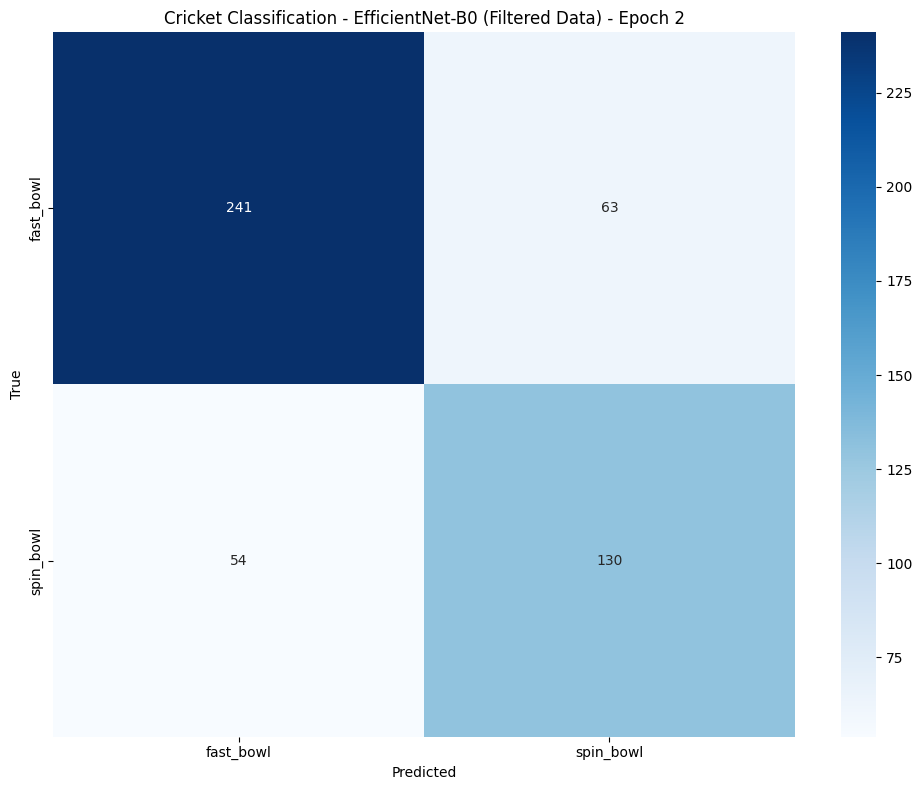

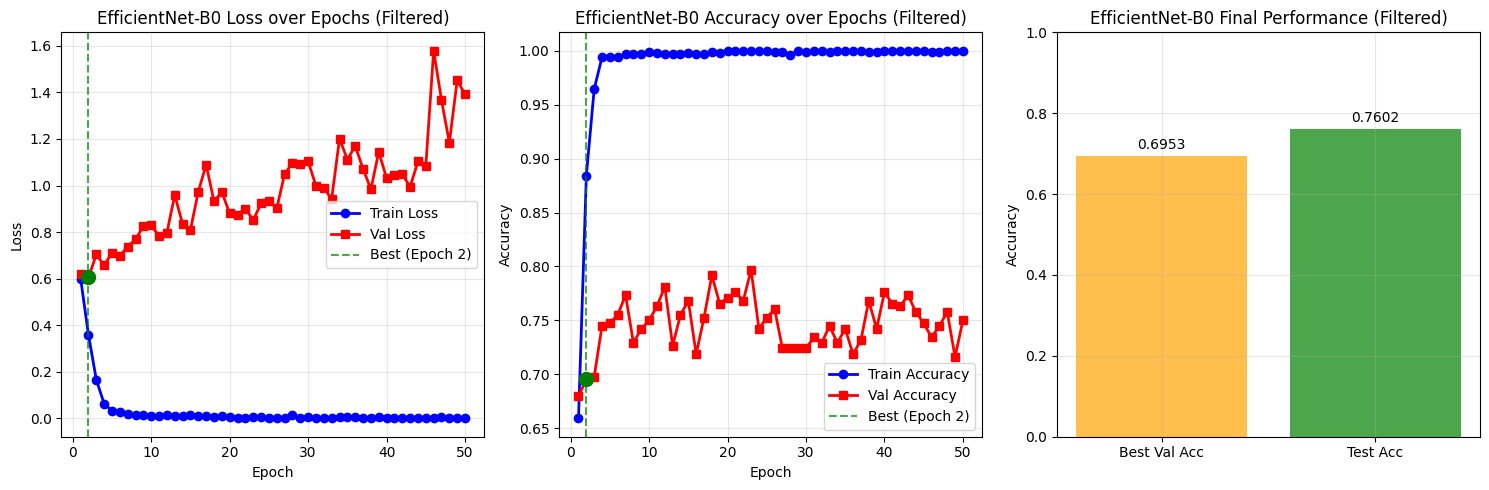


⏰ Final Timing Summary:
│ Total Training: 1196.91s (19.9 min)
│ Average per Epoch: 23.94s
│ Testing Time: 7.99s
│ Total Runtime: 1204.90s

⚡ EfficientNet-B0 + Filtered Data Benefits:
│ Clean dataset: 'random_occlusion' folder excluded
│ Compound scaling: Optimally balanced depth/width/resolution
│ Parameter efficient: ~5.3M parameters (vs ~25M ResNet50)
│ High accuracy: Often achieves excellent performance
│ Fast inference: Optimized for efficiency
│ Mobile-friendly: Designed for resource-constrained environments


In [8]:
# -----------------------------
# 3. Training Setup
# -----------------------------
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)  # Lower LR for fine-tuning

print(f"\n📋 Training Configuration:")
print(f"│ Model: EfficientNet-B0 (pretrained)")
print(f"│ Optimizer: Adam (lr={optimizer.param_groups[0]['lr']})")
print(f"│ Loss Function: CrossEntropyLoss")
print(f"│ Batch Size: 32")
print(f"│ Device: {device}")
print(f"│ Data: Filtered (excluding '{ignore_folder}')")

# -----------------------------
# 4. Training Loop with Model Saving
# -----------------------------
train_losses, val_losses = [], []
train_accs, val_accs = [], []
epoch_times = []
epochs = 50

# Initialize best model tracking (using val_loss for fine-tuning)
best_val_loss = float('inf')
best_model_state = None
best_epoch = 0
best_val_acc = 0.0

print(f"\n🚀 Starting EfficientNet-B0 Fine-tuning for {epochs} epochs...")
print("=" * 80)
total_start_time = time.time()

for epoch in range(epochs):
    epoch_start_time = time.time()
    
    print(f"\n📈 Epoch {epoch+1}/{epochs}")
    print("-" * 50)
    
    # Training Phase
    print("🔄 Training Phase...")
    model.train()
    running_loss, correct, total = 0, 0, 0
    
    train_pbar = tqdm(train_loader, desc="Training", 
                     bar_format='{l_bar}{bar:30}{r_bar}{bar:-30b}')
    
    train_phase_start = time.time()
    
    for batch_idx, (imgs, labels) in enumerate(train_pbar):
        imgs, labels = imgs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        
        current_acc = correct / total
        train_pbar.set_postfix({
            'Loss': f'{running_loss/(batch_idx+1):.4f}',
            'Acc': f'{current_acc:.4f}'
        })
        
        if device.type == 'cuda' and batch_idx % 10 == 0:
            gpu_memory = torch.cuda.memory_allocated() / 1024**3
            train_pbar.set_postfix({
                'Loss': f'{running_loss/(batch_idx+1):.4f}',
                'Acc': f'{current_acc:.4f}',
                'GPU': f'{gpu_memory:.1f}GB'
            })
    
    train_phase_time = time.time() - train_phase_start
    train_loss = running_loss / len(train_loader)
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    
    print(f"✅ Training completed in {train_phase_time:.2f}s")
    
    # Validation Phase
    print("🔍 Validation Phase...")
    model.eval()
    running_loss, correct, total = 0, 0, 0
    
    val_phase_start = time.time()
    val_pbar = tqdm(val_loader, desc="Validation", 
                   bar_format='{l_bar}{bar:30}{r_bar}{bar:-30b}')
    
    with torch.no_grad():
        for batch_idx, (imgs, labels) in enumerate(val_pbar):
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            
            current_acc = correct / total
            val_pbar.set_postfix({
                'Loss': f'{running_loss/(batch_idx+1):.4f}',
                'Acc': f'{current_acc:.4f}'
            })
    
    val_phase_time = time.time() - val_phase_start
    val_loss = running_loss / len(val_loader)
    val_acc = correct / total
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    print(f"✅ Validation completed in {val_phase_time:.2f}s")
    
    # Check if this is the best model (using val_loss for fine-tuning)
    is_best = val_loss < best_val_loss
    if is_best:
        best_val_loss = val_loss
        best_val_acc = val_acc
        best_epoch = epoch + 1
        best_model_state = model.state_dict().copy()
        print(f"🌟 New best model found! Validation Loss: {val_loss:.4f}")
    
    # Epoch Summary
    epoch_time = time.time() - epoch_start_time
    epoch_times.append(epoch_time)
    
    print(f"\n📊 Epoch {epoch+1} Summary:")
    print(f"│ Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"│ Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.4f}")
    print(f"│ Train Time: {train_phase_time:.2f}s | Val Time: {val_phase_time:.2f}s")
    print(f"│ Total Epoch Time: {epoch_time:.2f}s")
    print(f"│ Best Val Loss: {best_val_loss:.4f} (Epoch {best_epoch})")
    
    if device.type == 'cuda':
        print(f"│ GPU Memory: {torch.cuda.memory_allocated()/1024**3:.1f}GB / {torch.cuda.memory_reserved()/1024**3:.1f}GB")
    
    print("=" * 80)

total_training_time = time.time() - total_start_time

# Save the best model
if best_model_state is not None:
    torch.save(best_model_state, 'best_cricket_efficientnetb0_filtered_pretrained.pth')
    print(f"\n💾 Best model saved as 'best_cricket_efficientnetb0_filtered.pth'")
    print(f"📊 Best model stats:")
    print(f"│ Best Epoch: {best_epoch}")
    print(f"│ Best Val Loss: {best_val_loss:.4f}")
    print(f"│ Best Val Acc: {best_val_acc:.4f}")

# Save training history
history_data = {
    'epoch': list(range(1, epochs+1)),
    'train_loss': train_losses,
    'val_loss': val_losses,
    'train_acc': train_accs,
    'val_acc': val_accs,
    'epoch_time': epoch_times
}

history_df = pd.DataFrame(history_data)
history_df.to_csv('cricket_efficientnetb0_filtered_history_pretrained.csv', index=False)
print("\n💾 Training history saved to 'cricket_efficientnetb0_filtered_history_pretrained.csv'")

print(f"\n🎉 EfficientNet-B0 Fine-tuning Complete!")
print(f"Total Training Time: {total_training_time:.2f}s ({total_training_time/60:.1f} minutes)")
print(f"Average Epoch Time: {np.mean(epoch_times):.2f}s")

# -----------------------------
# 5. Load Best Model and Test
# -----------------------------
print(f"\n🧪 Loading Best Model for Testing...")
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print(f"✅ Best model from epoch {best_epoch} loaded successfully!")

test_start_time = time.time()
y_true, y_pred = [], []
model.eval()
test_pbar = tqdm(test_loader, desc="Testing", 
                bar_format='{l_bar}{bar:30}{r_bar}{bar:-30b}')

with torch.no_grad():
    for imgs, labels in test_pbar:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

test_time = time.time() - test_start_time
test_accuracy = accuracy_score(y_true, y_pred)

print(f"✅ Testing completed in {test_time:.2f}s")
print("\n📋 Classification Report:")
print(classification_report(y_true, y_pred, target_names=classes))
print(f"🎯 Test Accuracy: {test_accuracy:.4f}")

# Performance Summary
print(f"\n📊 Cricket Classification Performance (EfficientNet-B0 - Filtered Data):")
print(f"│ Best Validation Loss: {best_val_loss:.4f} (Epoch {best_epoch})")
print(f"│ Best Validation Acc:  {best_val_acc:.4f} (Epoch {best_epoch})")
print(f"│ Final Test Accuracy:  {test_accuracy:.4f}")
print(f"│ Val-Test Gap:         {abs(best_val_acc - test_accuracy):.4f}")
print(f"│ Data Filtering: Excluded '{ignore_folder}' folder")

print(f"\n💾 Files saved:")
print(f"│ best_cricket_efficientnetb0_filtered.pth - Best model weights")
print(f"│ cricket_efficientnetb0_filtered_history.csv - Training metrics")

# -----------------------------
# 6. Visualizations
# -----------------------------
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title(f"Cricket Classification - EfficientNet-B0 (Filtered Data) - Epoch {best_epoch}")
plt.tight_layout()
plt.show()

# Training Curves
plt.figure(figsize=(15, 5))

# Loss Plot
plt.subplot(1, 3, 1)
plt.plot(range(1, epochs+1), train_losses, 'b-', label="Train Loss", marker='o', linewidth=2)
plt.plot(range(1, epochs+1), val_losses, 'r-', label="Val Loss", marker='s', linewidth=2)
plt.axvline(x=best_epoch, color='green', linestyle='--', alpha=0.7, label=f'Best (Epoch {best_epoch})')
plt.scatter([best_epoch], [best_val_loss], color='green', s=100, zorder=5)
plt.legend()
plt.title("EfficientNet-B0 Loss over Epochs (Filtered)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True, alpha=0.3)

# Accuracy Plot
plt.subplot(1, 3, 2)
plt.plot(range(1, epochs+1), train_accs, 'b-', label="Train Accuracy", marker='o', linewidth=2)
plt.plot(range(1, epochs+1), val_accs, 'r-', label="Val Accuracy", marker='s', linewidth=2)
plt.axvline(x=best_epoch, color='green', linestyle='--', alpha=0.7, label=f'Best (Epoch {best_epoch})')
plt.scatter([best_epoch], [best_val_acc], color='green', s=100, zorder=5)
plt.legend()
plt.title("EfficientNet-B0 Accuracy over Epochs (Filtered)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True, alpha=0.3)

# Final Performance
plt.subplot(1, 3, 3)
metrics = ['Best Val Acc', 'Test Acc']
values = [best_val_acc, test_accuracy]
colors = ['orange', 'green']
bars = plt.bar(metrics, values, color=colors, alpha=0.7)
plt.title("EfficientNet-B0 Final Performance (Filtered)")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.grid(True, alpha=0.3)
for bar, val in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width()/2, val + 0.01, 
             f'{val:.4f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Final Summary
print(f"\n⏰ Final Timing Summary:")
print(f"│ Total Training: {total_training_time:.2f}s ({total_training_time/60:.1f} min)")
print(f"│ Average per Epoch: {np.mean(epoch_times):.2f}s")
print(f"│ Testing Time: {test_time:.2f}s")
print(f"│ Total Runtime: {total_training_time + test_time:.2f}s")

# Model and Data Info
print(f"\n⚡ EfficientNet-B0 + Filtered Data Benefits:")
print(f"│ Clean dataset: '{ignore_folder}' folder excluded")
print(f"│ Compound scaling: Optimally balanced depth/width/resolution")
print(f"│ Parameter efficient: ~5.3M parameters (vs ~25M ResNet50)")
print(f"│ High accuracy: Often achieves excellent performance")
print(f"│ Fast inference: Optimized for efficiency")
print(f"│ Mobile-friendly: Designed for resource-constrained environments")